## 1. Tabular TD(0) for estimating $𝑣_𝜋$

여기서는 policy evaluation 만 봅니다. 앞으로 나올 Sarsa, Q-learning 등과 다르게 탐험을 통해 policy를 개선하지 않고, 주어진 정책 $\pi$에 대해 $v_\pi$를 계산만 합니다. 

이번 강의에서는 교재 Example 6.5: Windy Gridwoirld를 구현합니다. 우선 문제를 잘 읽어 보세요. 


Sample state values (bottom row): [np.float64(-129.7), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)]


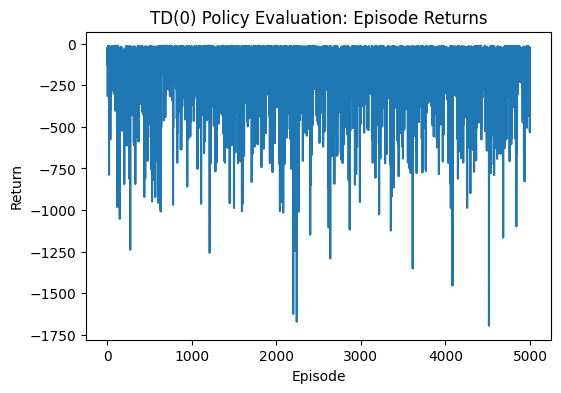

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ----- Environment -----
n_rows, n_cols = 4, 12
start = (3, 0)
goal  = (3, 11)
cliff = {(3, c) for c in range(1, 11)}
ACTIONS = [( -1, 0), ( 1, 0), ( 0,-1), ( 0, 1)]  # up, down, left, right
A_IDX = {0:"U",1:"D",2:"L",3:"R"}

def step(state, a_idx):
    r, c = state
    dr, dc = ACTIONS[a_idx]
    nr, nc = max(0, min(n_rows-1, r+dr)), max(0, min(n_cols-1, c+dc))
    ns = (nr, nc)
    if ns in cliff:
        return start, -100, True  # 절벽으로 떨어지면 시작점으로 돌아갑니다. 적절하게 큰 수를 음수 보상으로 줍니다.
    if ns == goal:
        return ns, -1, True
    return ns, -1, False

''' 
Policy evaluation만 해보는 알고리즘입니다. Policy를 만들어 보세요. Example 6.5 그림을 보고 교수가 만든 policy는 아래와 같습니다.
- 절벽 근처에 있을 때는 위쪽으로 가도록 선호도를 줍니다.
- 그 외에는 오른쪽으로 가도록 선호도를 줍니다.
- 목표 지점에서는 모든 행동을 동일한 확률로 선택합니다.
'''
pref = np.zeros((n_rows, n_cols, 4))
for r in range(n_rows):
    for c in range(n_cols):
        if (r, c) == goal: # goal state에 도착하면 아무 행동이나 선택합니다.
            continue
        if r == 3:
            pref[r, c, 0] = 1.0  # 맨 아래에 있으면 up 
        else:
            pref[r, c, 3] = 1.0  # 다른 곳에서는 일단 right

def pi_eps(state, epsilon=0.1):
    r, c = state
    if state == goal:
        probs = np.ones(4)/4
    else:
        greedy = np.argmax(pref[r, c])
        probs = np.ones(4) * (epsilon/4.0)
        probs[greedy] += 1.0 - epsilon
    a = np.random.choice(4, p=probs)
    return a, probs

# ----- TD(0) policy evaluation -----
gamma = 1.0
alpha = 0.1
episodes = 5000

V = np.zeros((n_rows, n_cols))
returns = []

for ep in range(episodes):
    s = start
    ep_return = 0
    while True:
        a, _ = pi_eps(s, pref, epsilon=0.1)   # ε-soft policy
        ns, r, done = step(s, a)

        if s != goal:
            V[s] += alpha * (r + gamma * (0 if done else V[ns]) - V[s]) # 매번 반복했지만 Terminal state 에서는 V'은 0입니다.

        ep_return += r
        s = ns
        if done:
            break
    returns.append(ep_return)

print("Sample state values (bottom row):", [round(V[3, c],1) for c in range(n_cols)])

plt.figure(figsize=(6,4))
plt.plot(returns)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("TD(0) Policy Evaluation: Episode Returns")
plt.show()

## 2. Sarsa (on-policy TD control) for estimating $𝑄≈𝑞_∗$

Greedy policy (U/D/L/R encoded as 0/1/2/3) bottom row: [0 0 0 0 0 0 0 0 0 0 0 0]


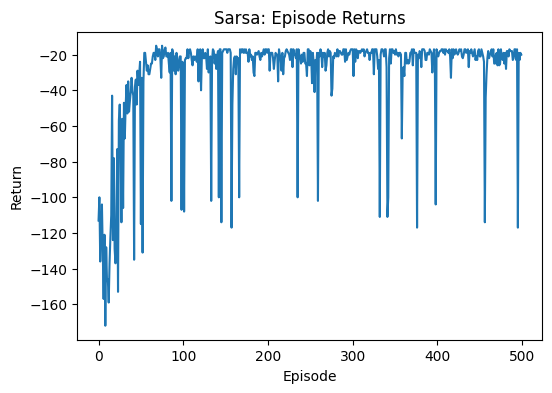

In [ ]:
# Sarsa (on-policy TD control) on 4x12 Cliff Walking
import numpy as np
import random
import matplotlib.pyplot as plt

# ----- Environment -----
n_rows, n_cols = 4, 12
start = (3, 0)
goal  = (3, 11)
cliff = {(3, c) for c in range(1, 11)}
ACTIONS = [( -1, 0), ( 1, 0), ( 0,-1), ( 0, 1)]  # up, down, left, right

def step(state, a_idx):
    r, c = state
    dr, dc = ACTIONS[a_idx]
    nr, nc = max(0, min(n_rows-1, r+dr)), max(0, min(n_cols-1, c+dc))
    ns = (nr, nc)
    if ns in cliff:
        return start, -100, True
    if ns == goal:
        return ns, -1, True
    return ns, -1, False

# ----- Sarsa -----
def eps_greedy(Q, s, eps):
    if np.random.rand() < eps:
        return np.random.randint(4)
    qs = Q[s[0], s[1]]
    max_a = np.argwhere(qs == np.max(qs)).flatten()
    return np.random.choice(max_a)

gamma = 1.0
alpha = 0.5
epsilon = 0.1
episodes = 500

Q = np.zeros((n_rows, n_cols, 4))
ep_returns = []   # 책에는 없지만, 성능 추적용 리스트 생성

for ep in range(episodes):
    s = start
    a = eps_greedy(Q, s, epsilon) # SARSA는 ε-greedy action selection입니다.
    ep_return = 0

    while True:
        ns, r, done = step(s, a)
        ep_return += r

        if done:
            # 터미널에서는 Q(ns, na)=0
            Q[s[0], s[1], a] += alpha * (r - Q[s[0], s[1], a])
            break

        na = eps_greedy(Q, ns, epsilon)
        td_target = r + gamma * Q[ns[0], ns[1], na]
        td_error  = td_target - Q[s[0], s[1], a]
        Q[s[0], s[1], a] += alpha * td_error

        s, a = ns, na

    ep_returns.append(ep_return)

policy = np.argmax(Q, axis=2)

print("Greedy policy (U/D/L/R encoded as 0/1/2/3) bottom row:", policy[3,:])

plt.figure(figsize=(6,4))
plt.plot(ep_returns)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Sarsa: Episode Returns")
plt.show()

## 3. Q-learning (off-policy TD control) for estimating $𝜋≈𝜋_∗$

Greedy policy (U/D/L/R encoded as 0/1/2/3) bottom row: [0 0 0 0 0 0 0 0 0 0 0 0]


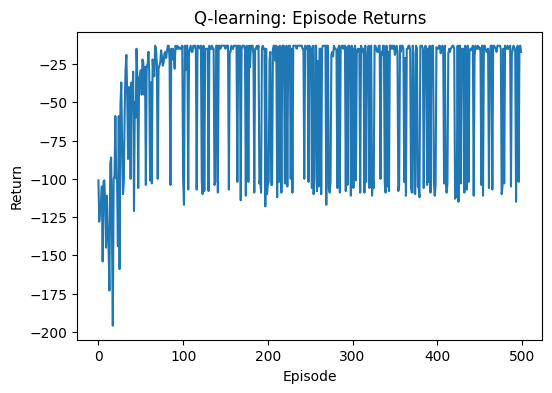

In [13]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ----- Environment -----
n_rows, n_cols = 4, 12
start = (3, 0)
goal  = (3, 11)
cliff = {(3, c) for c in range(1, 11)}
ACTIONS = [( -1, 0), ( 1, 0), ( 0,-1), ( 0, 1)]

def step(state, a_idx):
    r, c = state
    dr, dc = ACTIONS[a_idx]
    nr, nc = max(0, min(n_rows-1, r+dr)), max(0, min(n_cols-1, c+dc))
    ns = (nr, nc)
    if ns in cliff:
        return start, -100, True
    if ns == goal:
        return ns, -1, True
    return ns, -1, False

def eps_greedy(Q, s, eps):
    if np.random.rand() < eps:
        return np.random.randint(4)
    qs = Q[s[0], s[1]]
    max_a = np.argwhere(qs == np.max(qs)).flatten()
    return np.random.choice(max_a)

gamma = 1.0
alpha = 0.5
epsilon = 0.1
episodes = 500

Q = np.zeros((n_rows, n_cols, 4))
ep_returns = []

for ep in range(episodes):
    s = start
    a = eps_greedy(Q, s, epsilon)
    ep_return = 0

    while True:
        ns, r, done = step(s, a)
        ep_return += r

        if done:
            Q[s[0], s[1], a] += alpha * (r - Q[s[0], s[1], a])
            break

        # Q-learning은 다음 행동을 실제로 고르지 않고, max_a Q(ns, a) 사용
        td_target = r + gamma * np.max(Q[ns[0], ns[1]])
        td_error  = td_target - Q[s[0], s[1], a]
        Q[s[0], s[1], a] += alpha * td_error

        # 다음 스텝을 위해 행동은 여전히 ε-greedy로 선택
        a = eps_greedy(Q, ns, epsilon)
        s = ns

    ep_returns.append(ep_return)

policy = np.argmax(Q, axis=2)
print("Greedy policy (U/D/L/R encoded as 0/1/2/3) bottom row:", policy[3,:])

plt.figure(figsize=(6,4))
plt.plot(ep_returns)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Q-learning: Episode Returns")
plt.show()

## 4. Double Q-learning, for estimating $𝑄_1≈𝑄_2≈𝑞_∗$


Greedy policy (U/D/L/R encoded as 0/1/2/3) bottom row: [0 0 0 0 0 0 0 0 0 0 0 0]


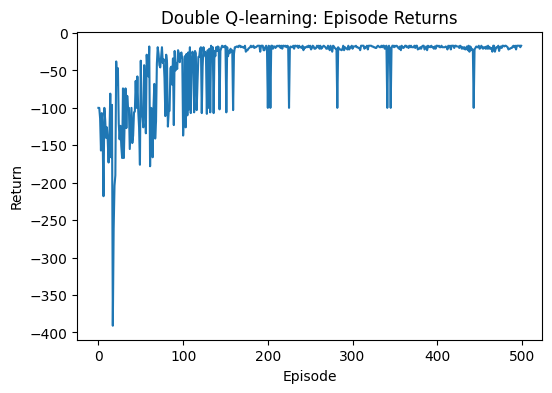

In [16]:
# Double Q-learning on 4x12 Cliff Walking
import numpy as np
import random
import matplotlib.pyplot as plt

# ----- Environment -----
n_rows, n_cols = 4, 12
start = (3, 0)
goal  = (3, 11)
cliff = {(3, c) for c in range(1, 11)}
ACTIONS = [( -1, 0), ( 1, 0), ( 0,-1), ( 0, 1)]

def step(state, a_idx):
    r, c = state
    dr, dc = ACTIONS[a_idx]
    nr, nc = max(0, min(n_rows-1, r+dr)), max(0, min(n_cols-1, c+dc))
    ns = (nr, nc)
    if ns in cliff:
        return start, -100, True
    if ns == goal:
        return ns, -1, True
    return ns, -1, False

def eps_greedy(Q1, Q2, s, eps):
    Qsum = Q1[s[0], s[1]] + Q2[s[0], s[1]]
    if np.random.rand() < eps:
        return np.random.randint(4)
    max_a = np.argwhere(Qsum == np.max(Qsum)).flatten()
    return np.random.choice(max_a)

gamma = 1.0
alpha = 0.5
epsilon = 0.1
episodes = 500

QA = np.zeros((n_rows, n_cols, 4))
QB = np.zeros((n_rows, n_cols, 4))
ep_returns = []

for ep in range(episodes):
    s = start
    a = eps_greedy(QA, QB, s, epsilon)  # 두 Q 합으로 정책 추정
    ep_return = 0

    while True:
        ns, r, done = step(s, a)
        ep_return += r

        if done:
            # 무작위로 하나만 업데이트
            if np.random.rand() < 0.5:
                QA[s[0], s[1], a] += alpha * (r - QA[s[0], s[1], a])
            else:
                QB[s[0], s[1], a] += alpha * (r - QB[s[0], s[1], a])
            break

        if np.random.rand() < 0.5:  # QA 업데이트
            a_star = np.argmax(QA[ns[0], ns[1]])  
            td_target = r + gamma * QB[ns[0], ns[1], a_star]
            td_error  = td_target - QA[s[0], s[1], a]
            QA[s[0], s[1], a] += alpha * td_error
        else:  # QB 업데이트
            a_star = np.argmax(QB[ns[0], ns[1]])  
            td_target = r + gamma * QA[ns[0], ns[1], a_star]
            td_error  = td_target - QB[s[0], s[1], a]
            QB[s[0], s[1], a] += alpha * td_error

        a = eps_greedy(QA, QB, ns, epsilon)  # 정책은 두 Q 합으로
        s = ns

    ep_returns.append(ep_return)

Qsum = QA + QB
policy = np.argmax(Qsum, axis=2)
print("Greedy policy (U/D/L/R encoded as 0/1/2/3) bottom row:", policy[3,:])

plt.figure(figsize=(6,4))
plt.plot(ep_returns)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Double Q-learning: Episode Returns")
plt.show()